In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
import sys

from smyleutils import averaging_utils as avg
from smyleutils import qboplot_utils as qbo
from smyleutils import colorbar_utils as cbars
from smyleutils import bootstrap_utils as boot
from smyleutils import mapplot_utils as mymaps
from smyleutils import zmplot_utils as zmplot
import cartopy.crs as ccrs

In [2]:
plotpath="/glade/campaign/cgd/cas/islas/python_plots/NCAR_CW3E_SMYLE/FIGURES/"

### Read in the QBO data

In [3]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/Uzm/"
uzm_era5_nov=xr.open_dataset(basepath+'Uzm_ERA5_day_init11.nc').Uzm
uzm_era5_nov_tr = avg.cosweightlat(uzm_era5_nov,-5,5).load()
uqbo = uzm_era5_nov_tr.interp(level=60.).sel(time=slice("1970-12-01","1971-02-28")).mean('time')
uqbo = uqbo - uqbo.mean('init_year')
uqbo_std = uqbo.std('init_year')

DataArrayWeighted with weights along dimensions: lat


### Read in the upper tropospheric zonal wind data

In [4]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/U_400_100_avg/"
era5 = xr.open_dataset(basepath+'U_400_100_avg_ERA5_init11.nc').__xarray_dataarray_variable__
l83 = xr.open_dataset(basepath+'U_400_100_avg_L83_init11.nc').__xarray_dataarray_variable__
l32 = xr.open_dataset(basepath+'U_400_100_avg_L32_init11.nc').__xarray_dataarray_variable__

# Making sure there are no inconsistences at high decimal points in the lon and lat
l83['lon'] = era5.lon ; l83['lat'] = era5.lat
l32['lon'] = era5.lon ; l32['lat'] = era5.lat

### Calculate DJF average

In [5]:
era5_djf = era5.sel(time=slice("1970-12-01","1971-02-28")).mean('time')
l83_djf = l83.sel(time=slice("1970-12-01","1971-02-28")).mean('time')
l32_djf = l32.sel(time=slice("1970-12-01","1971-02-28")).mean('time')

### Calculate the ensemble mean

In [6]:
l83_djf_em = l83_djf.mean('M')
l32_djf_em = l32_djf.mean('M')

### Calculate the lead dependent climatology and remove

In [7]:
era5_djf_clim = era5_djf.mean('init_year')
l83_djf_clim = l83_djf_em.mean('init_year')
l32_djf_clim = l32_djf_em.mean('init_year')

era5_djf_anoms = era5_djf - era5_djf_clim
l83_djf_anoms = l83_djf - l83_djf_clim
l32_djf_anoms = l32_djf - l32_djf_clim

### Read in the significance data (calculated at ~/DATA_SORT/signif/fig10/

In [8]:
signifdat = xr.open_dataset("/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/SIGNIF/fig10/ci_initmon11_DJF.nc")

### Calculate the ACC

In [9]:
acc_l83 = xr.corr(era5_djf_anoms, l83_djf_anoms.mean('M'), dim='init_year').load()
acc_l32 = xr.corr(era5_djf_anoms, l32_djf_anoms.mean('M'), dim='init_year').load()

### Calculate the MSSS

In [10]:
def calcmsss(mod,obs,dim='init_year'):
    mse_mod = (1./mod[dim].size)*((mod - obs)**2).sum('init_year')
    mse_obs = (1./mod[dim].size)*(obs**2).sum('init_year')
    msss = 1 - (mse_mod / mse_obs)
    
    # dealing with the levels where low top doesn't have any data
    msss = msss.where( msss != 1, nan)
    return msss

In [11]:
msss_l83 = calcmsss(l83_djf_anoms.mean('M'), era5_djf_anoms)
msss_l32 = calcmsss(l32_djf_anoms.mean('M'), era5_djf_anoms)

In [14]:
import warnings
warnings.filterwarnings('ignore')

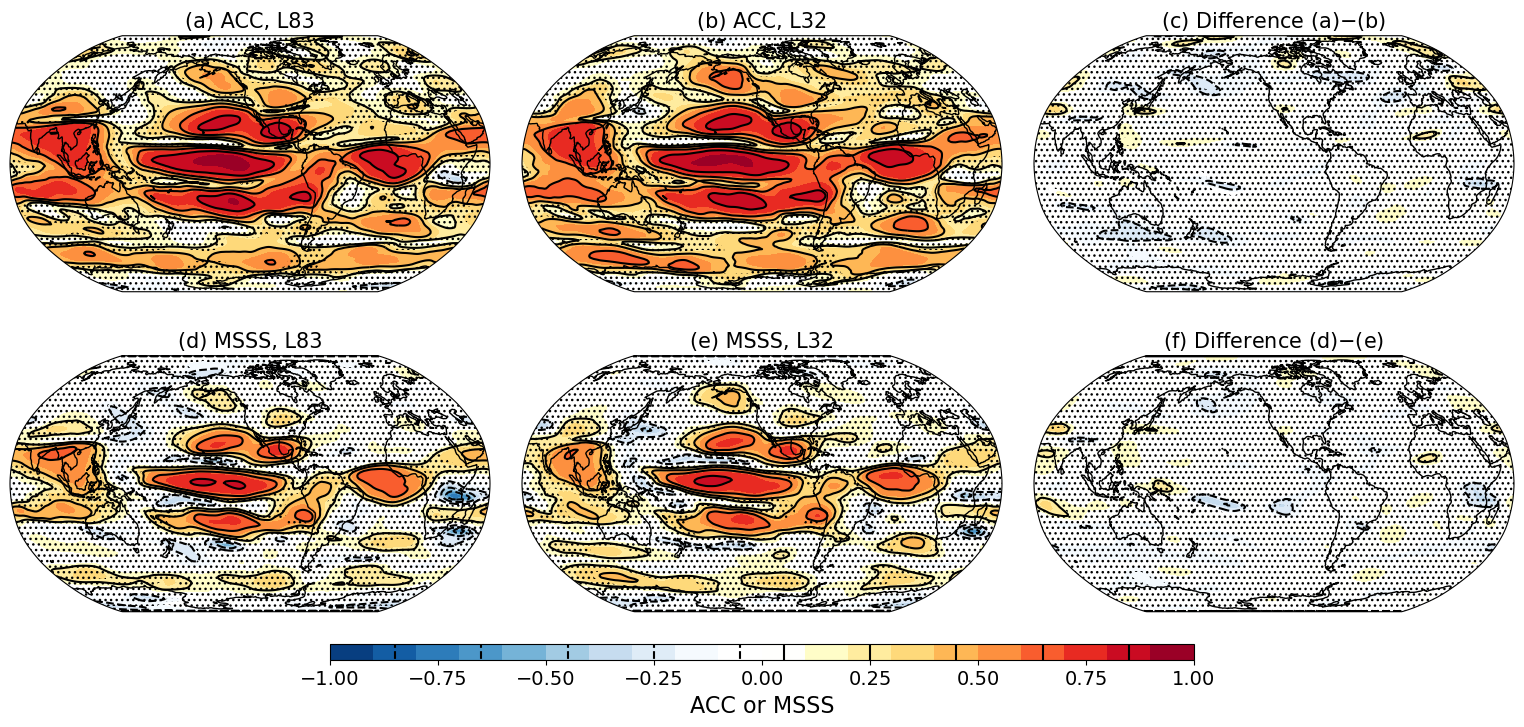

In [16]:
fig = plt.figure(figsize=(16,16))

signif1 = xr.DataArray(np.ones([signifdat.lat.size, signifdat.lon.size]),
                         coords=[signifdat.lat, signifdat.lon], dims=['lat','lon'])

signifplot = signif1.where( ~ ( (signifdat.min95_l83_cor > 0) | (signifdat.max95_l83_cor < 0)), nan)
ax = mymaps.contourmap_bothoceans_robinson_pos(fig, acc_l83, acc_l83.lon, acc_l83.lat, 0.1, -1, 1, '(a) ACC, L83',
                                               0.05,0.35,0.82,0.98, contourlines=True, contourlinescale=2, signifdat = signifplot, stipplesignif=True)

signifplot = signif1.where( ~(( signifdat.min95_l32_cor > 0) | (signifdat.max95_l32_cor < 0)), nan)
ax = mymaps.contourmap_bothoceans_robinson_pos(fig, acc_l32, acc_l32.lon, acc_l32.lat, 0.1, -1, 1, '(b) ACC, L32',
                                               0.37,0.67,0.82,0.98, contourlines=True, contourlinescale=2, signifdat = signifplot, stipplesignif=True)


signifplot = signif1.where( ~(( signifdat.min95_dif_cor > 0) | (signifdat.max95_dif_cor < 0)), nan)
ax = mymaps.contourmap_bothoceans_robinson_pos(fig, acc_l83 - acc_l32, acc_l83.lon, acc_l83.lat, 0.1, -1, 1, '(c) Difference (a)$-$(b)',
                                               0.69,0.99,0.82,0.98, contourlines=True, contourlinescale=2, signifdat = signifplot, stipplesignif=True)


signifplot = signif1.where( ~(( signifdat.min95_l83_msss > 0) | (signifdat.max95_l83_msss < 0)), nan)
ax = mymaps.contourmap_bothoceans_robinson_pos(fig, msss_l83, msss_l83.lon, msss_l83.lat, 0.1, -1, 1, '(d) MSSS, L83',
                                               0.05,0.35,0.62,0.78, contourlines=True, contourlinescale=2, signifdat = signifplot, stipplesignif=True)


signifplot = signif1.where( ~(( signifdat.min95_l32_msss > 0) | (signifdat.max95_l32_msss < 0)), nan)
ax = mymaps.contourmap_bothoceans_robinson_pos(fig, msss_l32, msss_l32.lon, msss_l32.lat, 0.1, -1, 1, '(e) MSSS, L32',
                                               0.37,0.67,0.62,0.78, contourlines=True, contourlinescale=2, signifdat = signifplot, stipplesignif=True)

signifplot = signif1.where( ~(( signifdat.min95_dif_msss > 0) | (signifdat.max95_dif_msss < 0)), nan)
ax = mymaps.contourmap_bothoceans_robinson_pos(fig, msss_l83 - msss_l32, msss_l83.lon, msss_l83.lat, 0.1, -1, 1, '(f) Difference (d)$-$(e)',
                                               0.69,0.99,0.62,0.78, contourlines=True, contourlinescale=2, signifdat = signifplot, stipplesignif=True)

ax = cbars.plotcolorbar(fig, 0.1, -1, 1, 'ACC or MSSS', 0.25,0.79,0.59,0.6, contourlines=True, contourlinescale=2)

fig.savefig(plotpath+'fig10.png', bbox_inches='tight', facecolor='white')

